In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import epub
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Text preparation and magical passages

In [3]:
book = epub.open_epub('GabrielGarciaMarquez-CienAnosDeSoledad.EPUB')
cienanos = []
for item in list(book.opf.manifest.values())[4:24]: 
    # read the content 
    data = book.read_item( item )
    if 'html' in item.href and 'chap' in item.href:
        print(item.href)
    #print data
    soup = BeautifulSoup(data, 'html.parser')
    raw = soup.prettify()
    chapter_num = soup.h1.text.strip()
    paragraphs = [par.get_text() for par in soup.find_all('div', class_='paragraph5')]
    cienanos.append((chapter_num, paragraphs))

In [4]:
paragraphs = []
for chapter in cienanos:
    for paragraph in chapter[1]:
        paragraphs.append(paragraph)
paragraphs = np.array(paragraphs)
print("There is %d paragraph of average length %.3f words"%(len(paragraphs), sum(len(s.split()) for s in paragraphs)/len(paragraphs)))

There is 840 paragraph of average length 164.005 words


Several passages we selected contained two different paragraphs, I chose to put them as two separate paragraphs

In [5]:
magical_passages = []
magical_passages.append("El niño, perplejo en la puerta, dijo: «Se va a caer.» La olla estaba bien puesta en el centro de la mesa, pero tan pronto como el niño hizo el anuncio, inició un movimiento irrevocable hacia el borde, como impulsada por un dinamismo interior, y se despedazó en el suelo. Úrsula, alarmada, le contó el episodio a su marido, pero éste lo interpretó como un fenómeno natural.")
magical_passages.append("la gallina que ponía un centenar de huevos de oro al son de la pandereta, y el mono amaestrado que adivinaba el pensamiento, y la máquina múltiple que servía al mismo tiempo para pegar botones y bajar la fiebre, y el aparato para olvidar los malos recuerdos, y el emplasto para perder el tiempo, y un millar de invenciones más, tan ingeniosas e insólitas, que José Arcadio Buendía hubiera querido inventar la máquina de la memoria para poder acordarse de todas")
magical_passages.append("Una tía de Úrsula, casada con un tío de José Arcadio Buendía tuvo un hijo que pasó toda la vida con unos pantalones englobados y flojos, y que murió desangrado después de haber vivido cuarenta y dos años en el más puro estado de virginidad porque nació y creció con una cola cartilaginosa en forma de tirabuzón y con una escobilla de pelos en la punta. Una cola de cerdo que no se dejó ver nunca de ninguna mujer, y que le costo la vida cuando un carnicero amigo le hizo el favor de cortársela con una hachuela de destazar.")
magical_passages.append("Dos noches después, Úrsula volvió a ver a Prudencio Aguilar en el baño, lavándose con el tapón de esparto la sangre cris-talizada del cuello. Otra noche lo vio paseándose bajo la lluvia. José Arcadio Buendía, fastidiado por las alucinaciones de su mujer, salió al patio armado con la lanza. Allí estaba el muerto con su expresión triste.")
magical_passages.append("Esta vez, entre muchos otros juegos de artificio, llevaban una estera voladora. Pero no la ofrecieron como un aporte fundamental al desarrollo del transporte, como un objeto de recreo. La gente, desde luego, desenterró sus últimos pedacitos de oro para disfrutar de un vuelo fugaz sobre las casas de la aldea.")
magical_passages.append("Estaba entre la multitud que presenciaba el triste espectáculo del hombre que se convirtió en víbora por desobedecer a sus padres.")
magical_passages.append("Un frasco vacío que durante mucho tiempo estuvo olvidado en un armario se hizo tan pesado que fue imposible moverlo. Una cazuela de agua colocada en la mesa de trabajo hirvió sin fuego durante media hora hasta evaporarse por completo. José Arcadio Buendía y su hijo observaban aquellos fenómenos con asustado alborozo, sin lograr explicárselos, pero interpretándolos como anuncios de la materia. Un día la canastilla de Amaranta empezó a moverse con un impulso propio y dio una vuelta completa en el cuarto, ante la consternación de Aureliano, que se apresuró a detenerla. Pero su padre no se alteró. Puso la canastilla en su puesto y la amarró a la pata de una mesa, convencido de que el acontecimiento esperado era inminente. Fue en esa ocasión cuando Aureliano le oyó decir:")
magical_passages.append("—Si no temes a Dios, témele a los metales.")
magical_passages.append("Pero la india les explicó que lo más temible de la enfermedad del insomnio no era la imposibilidad de dormir, pues el cuerpo no sentía cansancio alguno, sino su inexorable evolución hacia una manifestación más crítica: el olvido. Quería decir que cuando el enfermo se acostumbraba a su estado de vigilia, empezaban a borrarse de su memoria los recuerdos de la infancia, luego el nombre y la noción de las cosas, y por último la identidad de las personas y aun la conciencia del propio ser, hasta hundirse en una especie de idiotez sin pasado. José Arcadio Buendía, muerta de risa, consideró que se trataba de una de tantas dolencias inventadas por la superstición de los indígenas. Pero Úrsula, por si acaso, tomó la precaución de separar a Rebeca de los otros niños.")
magical_passages.append("—Un momento —dijo—. Ahora vamos a presenciar una prueba irrebatible del infinito poder de Dios.")
magical_passages.append("El muchacho que había ayudado a misa le llevó una taza de chocolate espeso y humeante que él se tomó sin respirar. Luego se limpió los labios con un pañuelo que sacó de la manga, extendió los brazos y cerró los ojos. Entonces el padre Nicanor se elevó doce centímetros sobre el nivel del suelo. Fue un recurso convincente. Anduvo varios días por entre las casas, repitiendo la prueba de la levitación mediante el estímulo del chocolate, mientras el monaguillo recogía tanto dinero en un talego, que en menos de un mes emprendió la construcción del templo. Nadie puso en duda el origen divino de la demostración, salvo José Arcadio Buendía, que observó sin inmutarse el tropel de gente que una mañana se reunió en torno al castaño para asistir una vez más a la revelación.")
magical_passages.append("El padre Nicanor trató de impresionar a las autoridades militares can el milagro de la levitación, y un soldado lo descalabró de un culatazo.")
magical_passages.append("Un hilo de sangre salió por debajo de la puerta, atravesó la sala, salió a la calle, siguió en un curso directo por los andenes disparejos, descendió escalinatas y subió pretiles, pasó de largo por la calle de los Turcos, dobló una esquina a la derecha y otra a la izquierda, volteó en ángulo recto frente a la casa de los Buendía, pasó por debajo de la puerta cerrada, atravesó la sala de visitas pegado a las paredes para no manchar los tapices, siguió por la otra sala, eludió en una curva amplia la mesa del comedor, avanzó por el corredor de las begonias y pasó sin ser visto por debajo de la silla de Amaranta que daba una lección de aritmética a Aureliano José, y se metió por el granero y apareció en la cocina donde Úrsula se disponía a partir treinta y seis huevos para el pan.")
magical_passages.append("—¡Ave María Purísima! —gritó Úrsula.")
magical_passages.append("Aunque en los meses siguientes reforzaron la tumba con muros superpuestos y echaron entre ellos ceniza apelmazada, aserrín y cal viva, el cementerio siguió oliendo a pólvora hasta muchos años después, cuando los ingenieros de la compañía bananera recubrieron la sepultura con una coraza de hormigón.")
magical_passages.append("Salió a la calle en una ocasión, ya muy vieja, con unos zapatos color de plata antigua y un sombrero de flores minúsculas, por la época en que pasó por el pueblo el Judío Errante y provocó un calor tan intenso que los pájaros rompían las alambreras de las ventanas para morir en los dormitorios")
magical_passages.append("No sólo era tan pesado como siempre, sino que en 511 prolongada estancia bajo el castaño había desarrollado la facultad de aumentar de peso volunta-riamente, hasta el punto de que siete hombres no pudieron con él y tuvieron que llevarlo a rastras a la cama.")
magical_passages.append("Poco después, cuando el carpintero le tomaba las medidas para el ataúd, vieron a través de la ventana que estaba cayendo una llovizna de minúsculas flores amarillas. Cayeron toda la noche sobre el pueblo en una tormenta silenciosa, y cubrieron los techos y atascaron las puertas, y sofocaron a los animales que durmieron a la intemperie. Tantas flores cayeron del cielo, que las calles amanecieron tapizadas de una colcha compacta, y tuvieron que despejarías con palas y rastrillos para que pudiera pasar el entierro.")
magical_passages.append("Un frío interior que le rayaba las huesos y lo mortificaba inclusive a pleno salle impidió dormir bien varias meses, hasta que se le convirtió en una costumbre.")
magical_passages.append("Hasta el principio de la adolescencia fueron dos mecanismos sincrónicos. Despertaban al mismo tiempo, sentían deseos de ir al baño a la misma hora, sufrían los mismos trastornos de salud y hasta sonaban las mismas cosas. En la casa, donde se creía que coordinaban sus actos por el simple deseo de confundir, nadie se dio cuenta de la realidad hasta un día en que Santa Sofía de la Piedad le dio a uno un vaso de limonada, y más tardó en probarlo que el otro en decir que le faltaba azúcar. Santa Sofía de la Piedad, que en efecto había olvidado ponerle azúcar a la limonada, se lo contó a Úrsula. «Así son todos —dijo ella, sin sorpresa—. Locos de nacimiento.»")
magical_passages.append("Pero cuando Aureliano Segundo abrió las ventanas entró una luz familiar que parecía acostumbrada a iluminar el cuarto todos los días, y no había el menor rastro de polvo o telaraña, sino que todo estaba barrido y limpio, mejor barrido y más limpio que el día del entierro, y la tinta no se había secado en el tintero ni el óxido había alterado el brillo de los metales, ni se había extinguido el rescoldo del atanor donde José Arcadio Buendía vaporizó el mercurio.")
magical_passages.append("Aunque carecía de pastas y el título no aparecía por ninguna parte, el niño gozaba con la historia de una mujer que se sentaba a la mesa y sólo comía granos de arroz que prendía con alfileres, y con la historia del pescador que le pidió prestado a su vecino un plomo para su red y el pescado con que lo recompensó más tarde tenía un diamante en el estómago, y con la lámpara que satisfacía los deseos y las alfombras que volaban. Asombrado, le preguntó a Úrsula si todo aquello era verdad, y ella le contentó que sí, que muchos años antes los gitanos llevaban a Macondo las lámparas maravillosas y las esteras voladoras.")
magical_passages.append("—Lo que pasa —suspiró— es que el mundo se va acabando poco a poco y ya no vienen esas cosas.")
magical_passages.append("Sus yeguas parían trillizos, las gallinas ponían dos veces al día, y los cerdos engordaban con tal desenfreno, que nadie podía explicarse tan desordenada fecundidad, como no fuera por artes de magia.")
magical_passages.append("Le bastaba con llevar a Petra Cotes a sus criaderos, y pasearla a caballo por sus tierras, para que todo animal marcado con su hierro sucumbiera a la peste irremediable de la proliferación.")
magical_passages.append("De regreso a casa, cuando el menor quiso limpiarse la frente descubrió que la mancha era indeleble, y que lo eran también las de sus hermanos. Probaron con agua y jabón con tierra y estropajo, y por último con piedra pómez y lejía y no con siguieron borrarse la cruz. En cambio, Amaranta y los demás que fueron a misa se la quitaron sin dificultad. «Así van mejor —los despidió Úrsula—. De ahora en adelante nadie podrá confundirlos.»")
magical_passages.append("Era un intrincado frangollo de verdades y espejismos, que convulsionó de impaciencia al espectro de José Arcadio Buendía bajo el castaño y lo obligó a caminar por toda la casa aun a pleno día.")
magical_passages.append("Tenía un negocio de globos cautivos, que había llevado por medio mundo con excelentes ganancias, pero no había conseguido elevar a nadie en Macondo porque consideraban ese invento como un retroceso, después de haber visto y probado las esteras voladoras de los gitanos.")
magical_passages.append("Fue en esa ocasión cuando construyeron una fortaleza de hormigón sobre la descolorida tumba de José Arcadio, para que el olor a pólvora del cadáver no contaminara las aguas.")
magical_passages.append("Acabó de decirlo, cuando Fernanda sintió que un delicado viento de luz le arrancó las sábanas de las manos y las desplegó en toda su amplitud. Amaranta sintió un temblor misterioso en los encajes de sus pollerinas y trató de agarrarse de la sábana para no caer, en el instante en que Remedios, la bella, empezaba a elevarse. Úrsula, ya casi ciega, fue la única que tuvo serenidad para identificar la naturaleza de aquel viento irreparable, y dejó las sábanas a merced de la luz, viendo a Remedios, la bella, que le decía adiós con la mano, entre el deslumbrante aleteo de las sábanas que subían con ella, que abandonaban con ella el aire de los escarabajos y las dalias, y pasaban con ella a través del aire donde terminaban las cuatro de la tarde, y se perdieron con ella para siempre en los altos aires donde no podían alcanzarla ni los más altos pájaros de la memoria.")
magical_passages.append("El coronel Aureliano Buendía era el único habitante de la casa que no seguía viendo al potente anciano agobiado por medio siglo de intemperie. «Saluda a tu padre», le dijo Úrsula. Él se detuvo un instante frente al castaño, y una vez más comprobó que tampoco aquel espacio vacío le suscitaba ningún afecto.")
magical_passages.append("Faltaba tanto para que saliera el sol que José Arcadio Buendía dormitaba todavía bajo el cobertizo de palmas podridas por la llovizna. Él no lo vio, como no lo había visto nunca, ni oyó la frase incomprensible que le dirigió el espectro de su padre cuando despertó sobresaltado por el chorro de orín caliente que le salpicaba los zapatos.")
magical_passages.append("Detuvo la mirada en el espacio donde Aureliano Segundo y Santa Sofía de la Piedad seguían viendo a José Arcadio Segundo, y también éste se dio cuenta de que el militar lo estaba mirando sin verlo. Luego apagó la luz y ajusté la puerta. Cuando les habló a los soldados, entendió Aureliano Segundo que el joven militar había visto el cuarto con los mismos ojos con que lo vio el coronel Aureliano Buendía.")
magical_passages.append("Llovió cuatro años, once meses y dos días.")
magical_passages.append("Amaranta Úrsula y Aureliano la llevaban y la traían por el dormitorio, la acostaban en el altar para ver que era apenas más grande que el Niño Dios, y una tarde la escondieron en un armario del granero donde hubieran podido comérsela las ratas.")
magical_passages.append("La enterraron en una cajita que era apenas más grande que la canastilla en que fue llevado Aureliano")
magical_passages.append("Cuando se levantaron, ya un grupo de hombres estaba desensartando al monstruo de las afiladas varas que habían parado en el fondo de una fosa cubierta con hojas secas, y había dejado de berrear. Pesaba como un buey, a pesar de que su estatura no era mayor que la de un adolescente, y de sus heridas manaba una sangre verde y untuosa. Tenía el cuerpo cubierto de una pelambre áspera, plagada de garrapatas menudas, y el pellejo petrificado por una costra de rémora, pero al contrario de la descripción del párroco, sus partes humanas eran más de ángel valetudinario que de hombre, porque las manos eran tersas y hábiles, los ojos grandes y crepusculares, y tenía en los omoplatos los muñones cicatrizados y callosos de unas alas potentes, que debieron ser desbastadas con hachas de labrador.")
magical_passages.append("En el cuartito apartado, adonde nunca llegó el viento árido, ni el polvo ni el calor, ambos recordaban la visión atávica de un anciano con sombrero de alas de cuervo que hablaba del mundo a espaldas de la ventana, muchos años antes de que ellos nacieran. Ambos descubrieron al mismo tiempo que allí siempre era marzo y siempre era lunes, y entonces comprendieron que José Arcadio Buendía no estaba tan loco como contaba la familia, sino que era el único que había dispuesto de bastante lucidez para vislumbrar la verdad de que también el tiempo sufría tropiezos y accidentes, y podía por tanto astillarse y dejar en un cuarto una fracción eternizada")
magical_passages.append("Divertidos por la impunidad de sus travesuras, cuatro niños entraron otra mañana en el cuarto, mientras Aureliano estaba en la cocina, dispuestos a destruir los pergaminos.")
magical_passages.append("Muchas veces fueron despertados por el tráfago de los muertos. Oyeron a Úrsula peleando con las leyes de la creación para preservar la estirpe, y a José Arcadio Buendía buscando la verdad quimérica de los grandes inventos, y a Fernanda rezando y al coronel Aureliano Buendía embruteciéndose con engaños de guerras y pescaditos de oro, y a Aureliano Segundo agonizando de soledad en el aturdimiento de las parrandas, y entonces aprendieron que las obsesiones dominantes prevalecen contra la muerte, y volvieron a ser felices con la certidumbre de que ellos seguirían amándose con sus naturalezas de aparecidos, mucho después de que otras especies de animales futuros les arrebataran a los insectos el paraíso de miseria que los insectos estaban acabando de arrebatarles a los hombres.")
magical_passages.append("Sólo cuando lo voltearon boca abajo se dieron cuenta de que tenía algo más que el resto de los hombres, y se inclinaron para examinarlo. Era una cola de cerdo.")
magical_passages = np.array(magical_passages)
print("There is %d magical passages of average %.3f words."%(len(magical_passages), sum(len(s.split()) for s in magical_passages)/len(magical_passages)))

There is 41 magical passages of average 65.049 words.


We match each magical passage with its paragraph.

In [91]:
def find_paragraph_idx(text, paragraphs):
    for idx, paragraph in enumerate(paragraphs):
        if text in paragraph:
            return idx
magical_paragraphs_idx = np.array([find_paragraph_idx(t, paragraphs) for t in magical_passages])
magic = np.zeros_like(paragraphs, dtype=bool)
magic[magical_paragraphs_idx] = True
magical_paragraphs = paragraphs[magic]
non_magical_paragraphs = paragraphs[~magic]

print("We have %d paragraphs that match magical passages"%sum(magic))

We have 38 paragraphs that match magical passages


## NLP

The paragraphs are simply transformed into list of sentences which are themselves transformed into list of words.

Words were tokenized using the Standford NLP which has support for spanish.

In [ ]:
from nltk.parse.corenlp import *
parser = CoreNLPParser(url='http://127.0.0.1:9000')

paragraphs_tokenized = []
for paragraph in paragraphs:
    paragraphs_tokenized.append([])
    for sentence in nltk.sent_tokenize(paragraph, language='spanish'):
        paragraphs_tokenized[-1].append(list(parser.tokenize(sentence)))

In [144]:
import json
with open('paragraphs_tokenized.json', 'r', encoding='utf-8') as infile:
    paragraphs_tokenized = json.load(infile)
    paragraphs_tokenized = np.array([np.array([np.array(sentence) for sentence in paragraph]) for paragraph in paragraphs_tokenized])

## Words and Sentence comparison

In [146]:
def dfs_for_paragraphs(paragraphs_tokenized):
    words_per_sentence = []
    sentence_per_paragraph = []
    words_per_paragraph = []

    for paragraph in paragraphs_tokenized:
        sentence_per_paragraph.append(len(paragraph))
        words_per_paragraph.append(0)
        for sentence in paragraph:
            num_words = len(sentence)
            words_per_sentence.append(num_words)
            words_per_paragraph[-1] += num_words
    per_sentence_df = pd.DataFrame(words_per_sentence, columns=['Words per sentence'])
    per_paragraph_df = pd.DataFrame(np.stack([np.array(sentence_per_paragraph), np.array(words_per_paragraph)], axis=1), columns=['Sentence per paragraph', 'Words per paragraph'])
    return per_sentence_df, per_paragraph_df

In [147]:
per_sentence_df, per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized)

stats_df = pd.concat([per_sentence_df.describe(), per_paragraph_df.describe()], axis=1)

not_magic_per_sentence_df, not_magic_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[~magic])

stats_df = pd.concat([stats_df, not_magic_per_sentence_df.describe(), not_magic_per_paragraph_df.describe()], axis=1)

magic_per_sentence_df, magic_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[magic])

stats_df = pd.concat([stats_df, magic_per_sentence_df.describe(), magic_per_paragraph_df.describe()], axis=1)

col_index = pd.MultiIndex.from_product([['All', 'Not Magic', 'Magic'], ['Words/sentence', 'Sentences/Par', 'Words/Par']])
stats_df = pd.DataFrame(stats_df.values, columns=col_index, index=stats_df.index)
stats_df

All                                 Not Magic                \
      Words/sentence Sentences/Par    Words/Par Words/sentence Sentences/Par   
count    5336.000000    840.000000   840.000000    4873.000000     802.00000   
mean       29.661919      6.352381   188.423810      29.339421       6.07606   
std        25.296303      7.040975   241.639457      25.379034       6.84685   
min         2.000000      1.000000     3.000000       2.000000       1.00000   
25%        14.000000      1.000000    18.000000      14.000000       1.00000   
50%        26.000000      3.000000    85.500000      26.000000       3.00000   
75%        40.000000      9.000000   297.000000      39.000000       9.00000   
max      1142.000000     50.000000  1672.000000    1142.000000      50.00000   

                            Magic                             
         Words/Par Words/sentence Sentences/Par    Words/Par  
count   802.000000     463.000000     38.000000    38.000000  
mean    178.268080      33.056156     12.184211   402.763158  
std     232.941976      24.175071      8.526129   316.081364  
min       3.000000       3.000000      1.000000    10.000000  
25%      18.000000      17.000000      4.250000   183.000000  
50%      69.000000      29.000000     12.500000   355.000000  
75%     280.750000      41.500000     15.750000   518.750000  
max    1672.000000     190.000000     34.000000  1348.000000

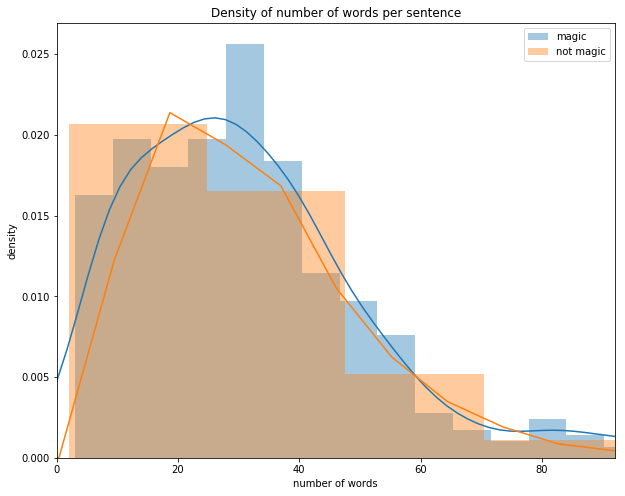

In [148]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(magic_per_sentence_df, ax=ax,hist=True, label='magic')
sns.distplot(not_magic_per_sentence_df, ax=ax, hist=True, label='not magic')
ax.set_xlim(0, per_sentence_df.quantile(0.99).max());
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of words per sentence")
ax.legend();

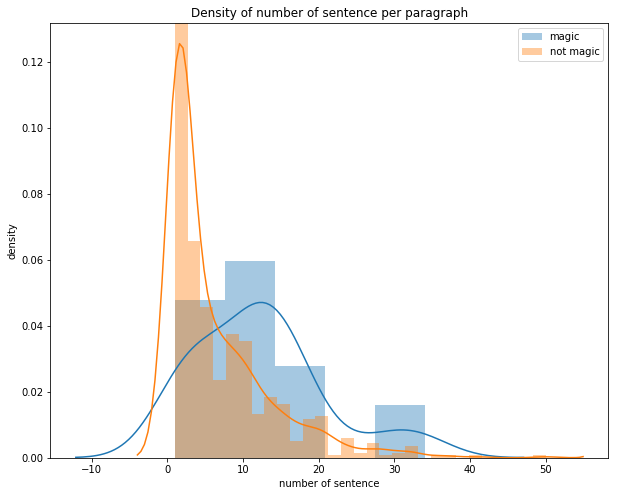

In [149]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(magic_per_paragraph_df['Sentence per paragraph'], ax=ax, label='magic')
sns.distplot(not_magic_per_paragraph_df['Sentence per paragraph'], ax=ax, label='not magic')
# ax.set_xlim(0, not_magic_per_paragraph_df['Sentence per paragraph'].quantile(0.99));
ax.set_ylabel("density")
ax.set_xlabel("number of sentence")
ax.set_title("Density of number of sentence per paragraph")
ax.legend();

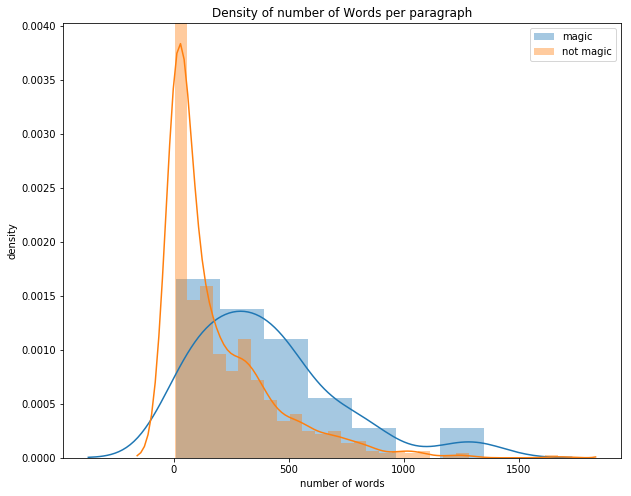

In [150]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(magic_per_paragraph_df['Words per paragraph'], ax=ax, label='magic')
sns.distplot(not_magic_per_paragraph_df['Words per paragraph'], ax=ax, label='not magic')
# ax.set_xlim(0, not_magic_per_paragraph_df['Words per paragraph'].quantile(0.99));
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of Words per paragraph")
ax.legend();

### Sanity check with random paragraphs

In [151]:
random_per_sentence_df, random_per_paragraph_df = dfs_for_paragraphs(np.random.choice(paragraphs_tokenized[~magic], sum(magic)))
pd.concat([random_per_sentence_df.describe(), random_per_paragraph_df.describe()], axis=1)

,Words per sentence,Sentence per paragraph,Words per paragraph
count,257.000000,38.000000,38.000000
mean,29.894942,6.763158,202.184211
std,19.038218,8.787073,275.197802
min,3.000000,1.000000,5.000000
25%,13.000000,1.250000,16.250000
50%,27.000000,3.000000,61.000000
75%,42.000000,8.000000,282.250000
max,76.000000,41.000000,1076.000000


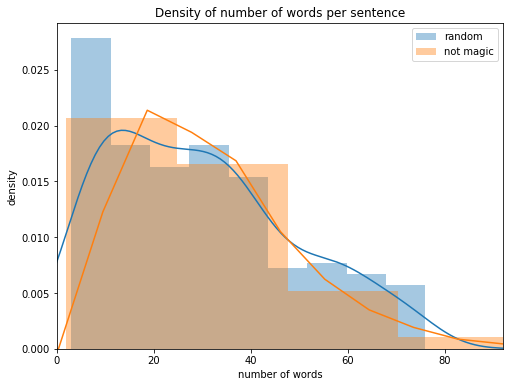

In [152]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(random_per_sentence_df, ax=ax,hist=True, label='random')
sns.distplot(not_magic_per_sentence_df, ax=ax, hist=True, label='not magic')
ax.set_xlim(0, per_sentence_df.quantile(0.99).max());
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of words per sentence")
ax.legend();

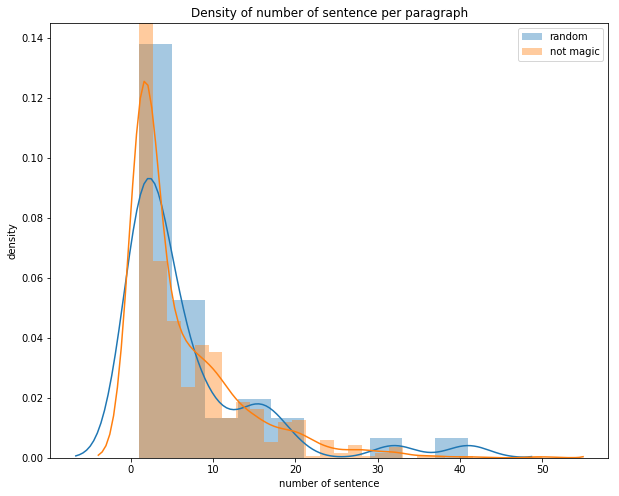

In [153]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(random_per_paragraph_df['Sentence per paragraph'], ax=ax, label='random')
sns.distplot(not_magic_per_paragraph_df['Sentence per paragraph'], ax=ax, label='not magic')
# ax.set_xlim(0, not_magic_per_paragraph_df['Sentence per paragraph'].quantile(0.99));
ax.set_ylabel("density")
ax.set_xlabel("number of sentence")
ax.set_title("Density of number of sentence per paragraph")
ax.legend();

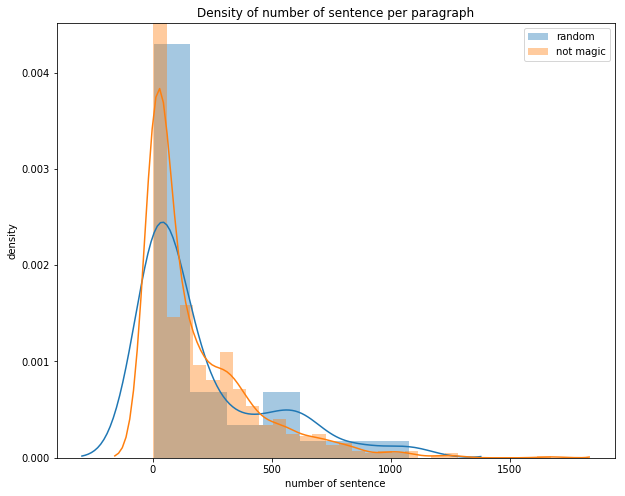

In [154]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(random_per_paragraph_df['Words per paragraph'], ax=ax, label='random')
sns.distplot(not_magic_per_paragraph_df['Words per paragraph'], ax=ax, label='not magic')
# ax.set_xlim(0, not_magic_per_paragraph_df['Sentence per paragraph'].quantile(0.99));
ax.set_ylabel("density")
ax.set_xlabel("number of sentence")
ax.set_title("Density of number of sentence per paragraph")
ax.legend();

Some check with K-S test, this test tries to reject the null hypothesis that both datasets are coming from the same distribution. 

In [155]:
print("Between magic and not magic:")
print("For Words per sentence:", scipy.stats.ks_2samp(magic_per_sentence_df['Words per sentence'], not_magic_per_sentence_df['Words per sentence']))
print("For Sentence per paragraph:", scipy.stats.ks_2samp(magic_per_paragraph_df['Sentence per paragraph'], not_magic_per_paragraph_df['Sentence per paragraph']))
print("For Words per paragraph:", scipy.stats.ks_2samp(magic_per_paragraph_df['Words per paragraph'], not_magic_per_paragraph_df['Words per paragraph']))
print("")
print("Between random and not magic:")
print("For Words per sentence:", scipy.stats.ks_2samp(random_per_sentence_df['Words per sentence'], not_magic_per_sentence_df['Words per sentence']))
print("For Sentence per paragraph:", scipy.stats.ks_2samp(random_per_paragraph_df['Sentence per paragraph'], not_magic_per_paragraph_df['Sentence per paragraph']))
print("For Words per paragraph:", scipy.stats.ks_2samp(random_per_paragraph_df['Words per paragraph'], not_magic_per_paragraph_df['Words per paragraph']))

Between magic and not magic:
For Words per sentence: Ks_2sampResult(statistic=0.08309462064294859, pvalue=0.005422253921074399)
For Sentence per paragraph: Ks_2sampResult(statistic=0.43096206851292823, pvalue=1.5008867823569327e-06)
For Words per paragraph: Ks_2sampResult(statistic=0.44159338495865597, pvalue=7.420679319512843e-07)

Between random and not magic:
For Words per sentence: Ks_2sampResult(statistic=0.05199379412166294, pvalue=0.5135897774056727)
For Sentence per paragraph: Ks_2sampResult(statistic=0.07074419215120098, pvalue=0.9912926925321597)
For Words per paragraph: Ks_2sampResult(statistic=0.08970993568709795, pvalue=0.9200186064690101)


The test shows that for the sentence and words per paragraph for magic and non-magic, there is a high change that is does not come from the same distribution, in the other cases, it seems to be from the same distribution.

### Text analysis
#### Word occurences

In [253]:
def normalize_counter(counter):
    count = sum(counter.values(), 0.0)
    for k in counter.keys():
        counter[k] /= count

In [997]:
stopwords = nltk.corpus.stopwords.words('spanish')
punctuation = list(punctuation)
punctuation.extend(['¿', '¡', '—', '«', '»'])
names = ['aureliano', 'úrsula', 'arcadio', 'josé', 'buendía', 'amaranta', 'fernanda', 'buendia', 'melquíades', 'macondo', 'rebeca', 'prudencio', 'crespi', 'meme']
others = ['tan', 'vez', 'después', 'si']

to_remove = stopwords + punctuation + names + others

In [998]:
words_not_magic = Counter([word.lower() for paragraph in paragraphs_tokenized[~magic] for sentence in paragraph for word in sentence if word.lower() not in to_remove])
normalize_counter(words_not_magic)
words_magic = Counter([word.lower() for paragraph in paragraphs_tokenized[magic] for sentence in paragraph for word in sentence if word.lower() not in to_remove])
normalize_counter(words_magic)

In [1014]:
pd.DataFrame(list(words_magic.values()), columns=['ocurrence in magic']).describe()

,ocurrence in magic
count,3438.000000
mean,0.000291
std,0.000374
min,0.000159
25%,0.000159
50%,0.000159
75%,0.000317
max,0.007612


In [1015]:
pd.DataFrame(list(words_not_magic.values()), columns=['ocurrence in not magic']).describe()

,ocurrence in not magic
count,14094.000000
mean,0.000071
std,0.000196
min,0.000017
25%,0.000017
50%,0.000017
75%,0.000052
max,0.007167


In [999]:
words_not_magic.most_common(20)

[('casa', 0.0071671588691432225),
 ('coronel', 0.005025646339567898),
 ('dijo', 0.0046802410928622005),
 ('segundo', 0.004628430305856346),
 ('entonces', 0.004334835846156503),
 ('tiempo', 0.004179403485138939),
 ('sino', 0.0034540524670569747),
 ('sólo', 0.003281349843704126),
 ('mientras', 0.0030395661710101375),
 ('dos', 0.002953214859333713),
 ('noche', 0.0029186743346631436),
 ('años', 0.0028150527606514344),
 ('hizo', 0.0025041880386163064),
 ('guerra', 0.0024005664646045972),
 ('día', 0.0023832962022693124),
 ('tarde', 0.002348755677598743),
 ('nadie', 0.002331485415263458),
 ('hombre', 0.002296944890592888),
 ('mismo', 0.0022451341035870337),
 ('mujer', 0.0022105935789164637)]

In [1000]:
words_magic.most_common(20)

[('casa', 0.007611798287345386),
 ('segundo', 0.006343165239454488),
 ('tiempo', 0.004281636536631779),
 ('nadie', 0.004281636536631779),
 ('cuarto', 0.004123057405645417),
 ('años', 0.0036473200126863306),
 ('entonces', 0.003330161750713606),
 ('coronel', 0.003330161750713606),
 ('siempre', 0.003171582619727244),
 ('dos', 0.003171582619727244),
 ('día', 0.0030130034887408817),
 ('sino', 0.0030130034887408817),
 ('pueblo', 0.0030130034887408817),
 ('puerta', 0.0028544243577545195),
 ('vida', 0.0026958452267681573),
 ('mientras', 0.002537266095781795),
 ('tres', 0.002537266095781795),
 ('padre', 0.002378686964795433),
 ('hizo', 0.002378686964795433),
 ('meses', 0.002378686964795433)]

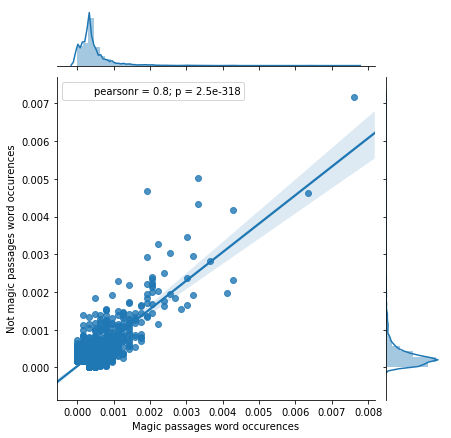

In [1001]:
top_n = 1000
all_words_top_n = list(set([x[0] for x in words_magic.most_common(top_n)])\
    .union(set([x[0] for x in words_not_magic.most_common(top_n)])))
words_magic_top_n = np.array([words_magic[word] for word in all_words_top_n])
words_not_magic_top_n = np.array([words_not_magic[word] for word in all_words_top_n])
g = sns.JointGrid(x=words_magic_top_n, y=words_not_magic_top_n)
g = g.plot(sns.regplot, sns.distplot)
g = g.annotate(scipy.stats.pearsonr)
g = g.set_axis_labels("Magic passages word occurences", "Not magic passages word occurences")

In [1002]:
n = 25
diff = (words_magic_top_n-words_not_magic_top_n)
n_in_magic = diff.argsort()[-n:][::-1]
n_not_in_magic = diff.argsort()[:n]

In [1003]:
pd.DataFrame(np.concatenate([np.array(all_words_top_n)[n_in_magic].reshape(-1,1), diff[n_in_magic].reshape(-1,1), words_magic_top_n[n_in_magic].reshape(-1,1), words_not_magic_top_n[n_in_magic].reshape(-1,1)], axis=1), columns=['term', 'diff', 'magic freq', 'not magic freq']).set_index('term')

,diff,magic freq,not magic freq
term,,,
cuarto,0.0021369772370876563,0.004123057405645417,0.0019860801685577605
nadie,0.001950151121368321,0.004281636536631779,0.002331485415263458
segundo,0.0017147349335981422,0.006343165239454488,0.004628430305856346
pueblo,0.001355058304553534,0.0030130034887408817,0.0016579451841873477
puerta,0.001300100747578881,0.0028544243577545195,0.0015543236101756386
siempre,0.001254583500510623,0.003171582619727244,0.001916999119216621
calle,0.001080270519680269,0.0022201078338090706,0.0011398373141288016
siguió,0.0010362896851033045,0.0017443704408499842,0.0007080807557466798
pasó,0.001033142915134506,0.001585791309863622,0.0005526483947291159


In [1004]:
pd.DataFrame(np.concatenate([np.array(all_words_top_n)[n_not_in_magic].reshape(-1,1), diff[n_not_in_magic].reshape(-1,1), words_magic_top_n[n_not_in_magic].reshape(-1,1), words_not_magic_top_n[n_not_in_magic].reshape(-1,1)], axis=1), columns=['term', 'diff', 'magic freq', 'not magic freq']).set_index('term')

,diff,magic freq,not magic freq
term,,,
dijo,-0.002777291521025854,0.0019029495718363464,0.0046802410928622005
coronel,-0.0016954845888542919,0.003330161750713606,0.005025646339567898
aquel,-0.0013721806769163947,0.0004757373929590866,0.0018479180698754813
primera,-0.0012403121181717126,0.0001585791309863622,0.0013988912491580748
hombre,-0.0011868909736883527,0.0011100539169045353,0.002296944890592888
sólo,-0.0010612420098950553,0.0022201078338090706,0.003281349843704126
noche,-0.0010157247628267971,0.0019029495718363464,0.0029186743346631436
corazón,-0.0010126519378442108,0.0003171582619727244,0.0013298101998169352
entonces,-0.0010046740954428967,0.003330161750713606,0.004334835846156503


#### Using word vectors

In [719]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [720]:
magic_sentences = [[word.lower() for word in sentence if word not in to_remove] for paragraph in paragraphs_tokenized[magic] for sentence in paragraph]
sentences = [[word.lower() for word in sentence if word.lower() not in to_remove] for paragraph in paragraphs_tokenized for sentence in paragraph]

In [723]:
model = gensim.models.Word2Vec(sentences, min_count=1, compute_loss=True, iter=5)

2018-04-23 10:00:53,073 : INFO : collecting all words and their counts
2018-04-23 10:00:53,074 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-23 10:00:53,095 : INFO : collected 14928 word types from a corpus of 64530 raw words and 5336 sentences
2018-04-23 10:00:53,096 : INFO : Loading a fresh vocabulary
2018-04-23 10:00:53,134 : INFO : min_count=1 retains 14928 unique words (100% of original 14928, drops 0)
2018-04-23 10:00:53,134 : INFO : min_count=1 leaves 64530 word corpus (100% of original 64530, drops 0)
2018-04-23 10:00:53,194 : INFO : deleting the raw counts dictionary of 14928 items
2018-04-23 10:00:53,195 : INFO : sample=0.001 downsamples 12 most-common words
2018-04-23 10:00:53,196 : INFO : downsampling leaves estimated 63753 word corpus (98.8% of prior 64530)
2018-04-23 10:00:53,249 : INFO : estimated required memory for 14928 words and 100 dimensions: 19406400 bytes
2018-04-23 10:00:53,250 : INFO : resetting layer weights
2018-04-23 10:0

In [898]:
magic_label = ['magic' if magic_sentences[idx] else 'not magic' for idx in range(len(magic_sentences))]

In [909]:
sentences_tagged = [gensim.models.doc2vec.TaggedDocument(words = words, tags=[idx]) for idx, words in enumerate(sentences)]
model_sentences = gensim.models.Doc2Vec(sentences_tagged, size=100, window=8, min_count=1)

2018-04-23 10:56:43,940 : INFO : collecting all words and their counts
2018-04-23 10:56:43,942 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-23 10:56:43,970 : INFO : collected 14928 word types and 5336 unique tags from a corpus of 5336 examples and 64530 words
2018-04-23 10:56:43,971 : INFO : Loading a fresh vocabulary
2018-04-23 10:56:44,007 : INFO : min_count=1 retains 14928 unique words (100% of original 14928, drops 0)
2018-04-23 10:56:44,008 : INFO : min_count=1 leaves 64530 word corpus (100% of original 64530, drops 0)
2018-04-23 10:56:44,053 : INFO : deleting the raw counts dictionary of 14928 items
2018-04-23 10:56:44,054 : INFO : sample=0.001 downsamples 12 most-common words
2018-04-23 10:56:44,055 : INFO : downsampling leaves estimated 63753 word corpus (98.8% of prior 64530)
2018-04-23 10:56:44,108 : INFO : estimated required memory for 14928 words and 100 dimensions: 21540800 bytes
2018-04-23 10:56:44,108 : INFO : resetting layer we

In [900]:
sentences[0]

['años',
 'frente',
 'pelotón',
 'fusilamiento',
 'coronel',
 'recordar',
 'aquella',
 'tarde',
 'remota',
 'padre',
 'llevó',
 'conocer',
 'hielo']

In [904]:
model_sentences.infer_vector(sentences[2])

array([-0.01359027, -0.01448111, -0.02582754, -0.03976386, -0.03032332,
        0.03093743, -0.05355566, -0.0096114 ,  0.03544744,  0.05679329,
        0.02162731,  0.01495054, -0.06004931,  0.01388516,  0.01766847,
       -0.04550124, -0.01274483,  0.01760248,  0.05369358,  0.02763892,
        0.01939833,  0.02823965, -0.05587459, -0.02272618, -0.05870264,
        0.0226475 , -0.05517389, -0.00669307, -0.00686005, -0.01320983,
       -0.05516356, -0.03784245,  0.04505423,  0.0189449 , -0.02488027,
        0.07088229,  0.00818528,  0.05472453, -0.02665695, -0.05861894,
       -0.06210564, -0.05413478,  0.00545641,  0.02444724,  0.04763862,
        0.02823905, -0.01578952, -0.02355443, -0.03063497,  0.02398456,
       -0.06121549,  0.00840633, -0.04544747, -0.04946443, -0.00032698,
        0.03915847, -0.00181356,  0.05494434,  0.06370249, -0.02446309,
        0.01121087, -0.02649847, -0.01211878, -0.00423891, -0.05085151,
       -0.02825752, -0.02377279,  0.02977594, -0.04349561,  0.03

[0.03002464 0.01195773 0.01187124 0.01173538 0.01152833 0.01147036
 0.01123984 0.01118532 0.01109964 0.01090751]


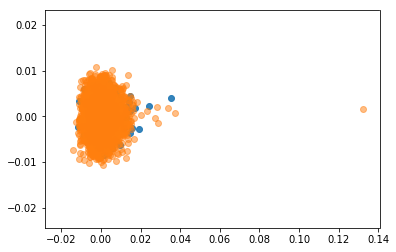

In [927]:
sentences_vec = np.array([model_sentences.docvecs[idx] for idx in range(len(sentences))])
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(sentences_vec)
print(pca.explained_variance_ratio_)
sentences_vec_proj = pca.transform(sentences_vec)
plt.scatter(sentences_vec_proj[magic_sentences][:,0], sentences_vec_proj[magic_sentences][:,1], alpha=0.9)
plt.scatter(sentences_vec_proj[~magic_sentences][:,0], sentences_vec_proj[~magic_sentences][:,1], alpha=0.5)

In [908]:
model_sentences.docvecs.most_similar([model_sentences.docvecs[0]])

[('not magic', 1.0000001192092896), ('magic', 0.999998152256012)]

In [805]:
sentences_vec = [np.sum([model.wv[word.lower()] for word in sentence], axis=0) for sentence in sentences]
sentences_vec = np.array([y if not isinstance(y, float) else np.zeros(100) for y in x])

In [806]:
magic_sentences = np.array([magic[idx] for idx, paragraph in enumerate(paragraphs_tokenized) for sentence in paragraph])

In [807]:
1 - magic_sentences.sum()/len(sentences)

0.9132308845577212

In [808]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(sentences_vec)
print(pca.explained_variance_ratio_)
sentences_vec_proj = pca.transform(sentences_vec)

[0.97124917 0.00116478]


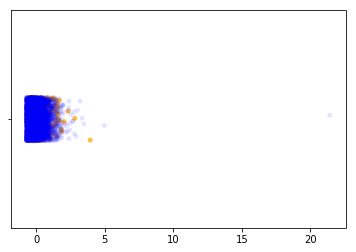

In [809]:
sns.stripplot(x=sentences_vec_proj[magic_sentences][:,0], jitter=True,color='orange',  alpha=0.7)
sns.stripplot(x=sentences_vec_proj[~magic_sentences][:,0], jitter=True, color='blue', alpha=0.1)

[0.97124917 0.00116478]


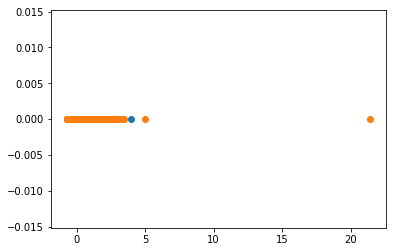

In [792]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(sentences_vec)
print(pca.explained_variance_ratio_)
sentences_vec_proj = pca.transform(sentences_vec)
plt.scatter(sentences_vec_proj[magic_sentences][:,0], sentences_vec_proj[magic_sentences][:,1])
plt.scatter(sentences_vec_proj[~magic_sentences][:,0], sentences_vec_proj[~magic_sentences][:,1])

In [759]:
random_sentences = np.zeros_like(sentences, dtype=bool)
random_sentences[np.random.randint(0, len(sentences), size=magic_sentences.sum())] = True

In [760]:
import sklearn

lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(x, magic_sentences)
print(lr.score(x, magic_sentences))
print(lr.score(x, random_sentences))

0.6564842578710645
0.6336206896551724


In [761]:
lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(x, random_sentences)
print(lr.score(x, random_sentences))
print(lr.score(x, magic_sentences))

0.6467391304347826
0.6212518740629686


In [592]:
model.wv.most_similar(positive=['coronel'])

[('guerra', 0.9996375441551208),
 ('armas', 0.9995791912078857),
 ('pidió', 0.9995691776275635),
 ('ver', 0.9995548129081726),
 ('sido', 0.9995187520980835),
 ('muerte', 0.9995184540748596),
 ('taller', 0.9995168447494507),
 ('dijo', 0.9995157122612),
 ('pudo', 0.9995152950286865),
 ('hijos', 0.9995118379592896)]